We show how to classify cats or dogs from images. It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

The dataset has the following directory structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

In [0]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [0]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [0]:
batch_size = 128
epochs = 50
IMG_HEIGHT = 150
IMG_WIDTH = 150

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [0]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

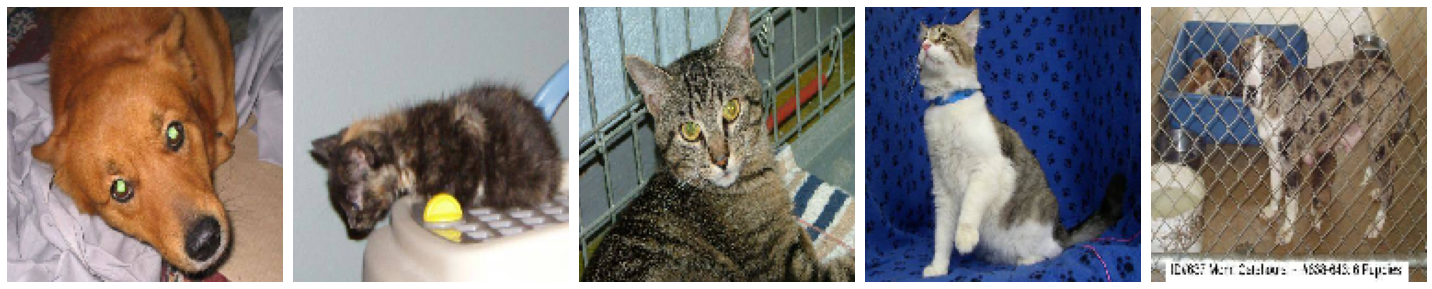

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])

### Create the Model

In [0]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [0]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
15/15 [==============================] - 7s 471ms/step - loss: 0.8218 - accuracy: 0.4866 - val_loss: 0.6904 - val_accuracy: 0.5022
Epoch 2/50
15/15 [==============================] - 7s 481ms/step - loss: 0.6870 - accuracy: 0.4974 - val_loss: 0.6733 - val_accuracy: 0.5078
Epoch 3/50
15/15 [==============================] - 7s 486ms/step - loss: 0.6755 - accuracy: 0.5486 - val_loss: 0.6840 - val_accuracy: 0.4989
Epoch 4/50
15/15 [==============================] - 7s 470ms/step - loss: 0.6489 - accuracy: 0.5807 - val_loss: 0.6242 - val_accuracy: 0.6116
Epoch 5/50
15/15 [==============================] - 7s 470ms/step - loss: 0.5860 - accuracy: 0.6608 - val_loss: 0.5846 - val_accuracy: 0.6953
Epoch 6/50
15/15 [==============================] - 7s 471ms/step - loss: 0.5373 - accuracy: 0.7228 - val_loss: 0.5786 - val_accuracy: 0.6920
Epoch 7/50
15/15 [==============================] - 7s 473ms/step - loss

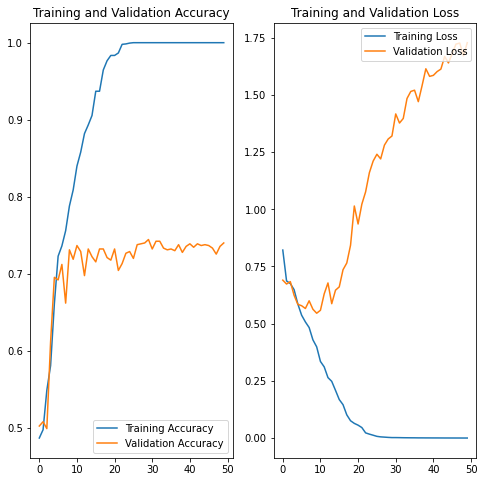

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As one can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around **70%** accuracy on the validation set.

### Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 70% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to our model.

### Data Augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the `ImageDataGenerator` class. Pass  different transformations to the dataset and it will take care of applying it during the training process.

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [0]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

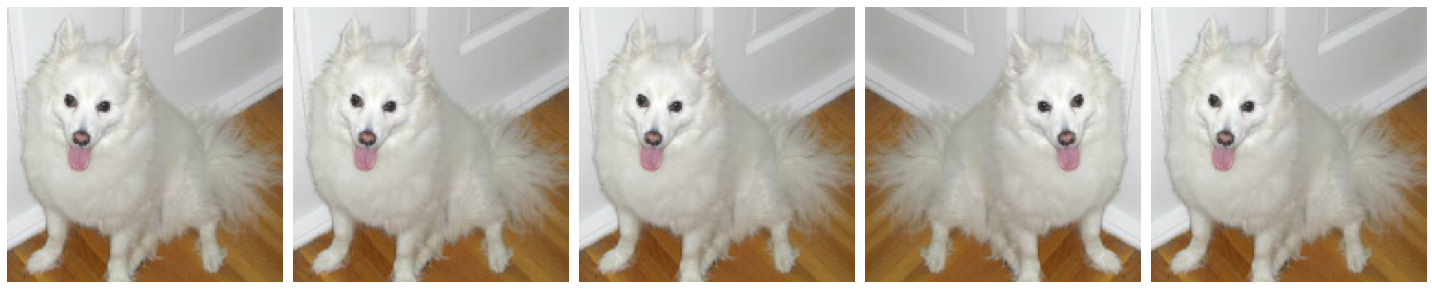

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

Let's take a look at a different augmentation called rotation and apply 45 degrees of rotation randomly to the training examples.

Found 2000 images belonging to 2 classes.


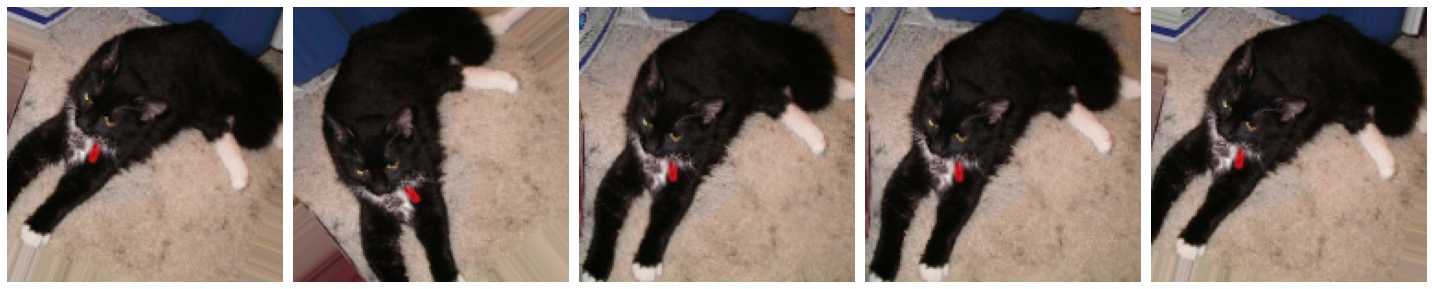

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

Found 2000 images belonging to 2 classes.


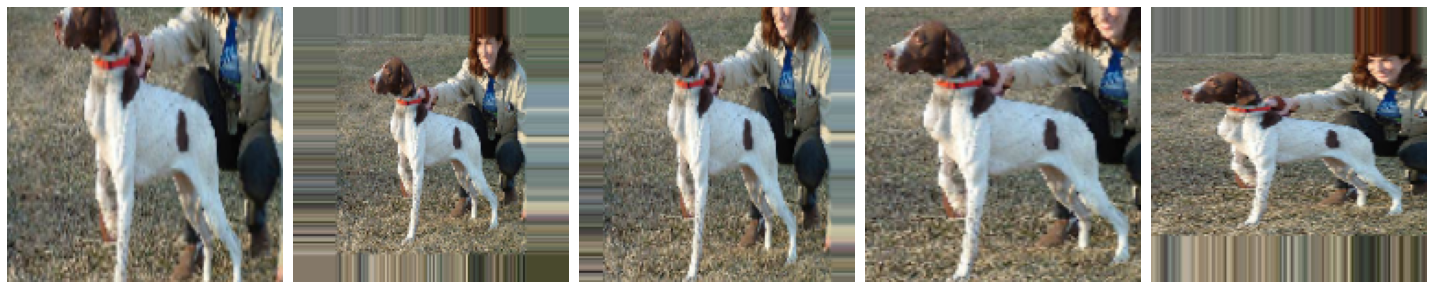

In [0]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) 
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

We apply all the previous augmentations. Here, we applied rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [0]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [0]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


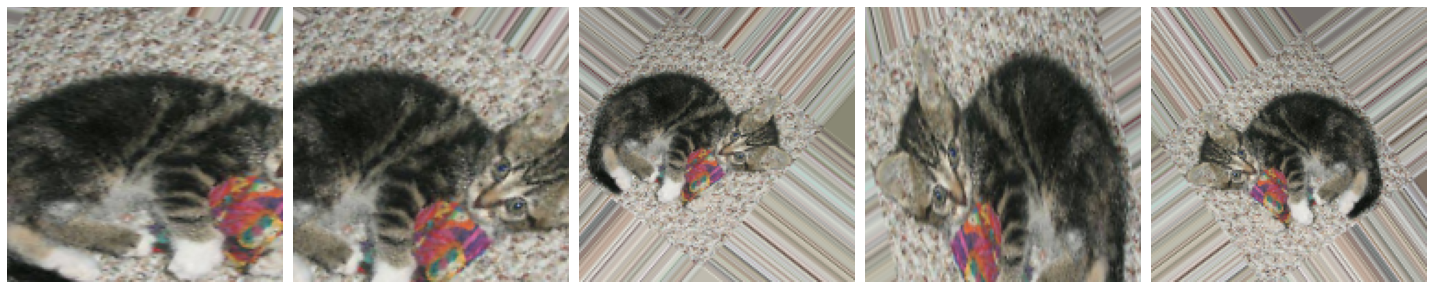

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


### Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in this tutorial

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

In [0]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [0]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

In [0]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/50
15/15 [==============================] - 15s 972ms/step - loss: 1.4475 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.5022
Epoch 2/50
15/15 [==============================] - 15s 986ms/step - loss: 0.6925 - accuracy: 0.5053 - val_loss: 0.6882 - val_accuracy: 0.4900
Epoch 3/50
15/15 [==============================] - 15s 977ms/step - loss: 0.6925 - accuracy: 0.5166 - val_loss: 0.6928 - val_accuracy: 0.5033
Epoch 4/50
15/15 [==============================] - 14s 965ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6925 - val_accuracy: 0.5100
Epoch 5/50
15/15 [==============================] - 15s 968ms/step - loss: 0.6921 - accuracy: 0.5048 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 6/50
15/15 [==============================] - 14s 966ms/step - loss: 0.6859 - accuracy: 0.5005 - val_loss: 0.6645 - val_accuracy: 0.5502
Epoch 7/50
15/15 [==============================] - 15s 972ms/step - loss: 0.6740 - accuracy: 0.5550 - val_loss: 0.6534 - val_accuracy: 0.6016

Visualize the metrics

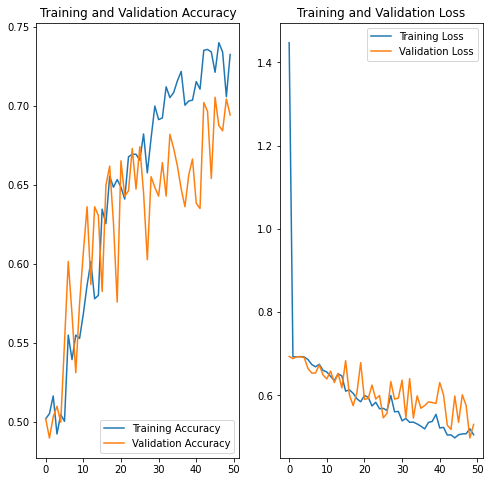

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

You can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs. Tinker the model with different set of hyperparameters. 